In [69]:
#import packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bisect import bisect
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# plot overlaid histogram of features in column for each class
def df_hist(class0, class1, column):
    nr_bins = 20
    bin_edges = np.histogram(np.r_[class0[column].values, class1[column].values], bins=nr_bins)[1]
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    hist0 = np.histogram(class0[column].values, bin_edges)[0]
    hist1 = np.histogram(class1[column].values, bin_edges)[0]
    plt.bar(bin_edges[0:nr_bins], hist0.astype(float)/sum(hist0), width, alpha=0.5, color='r', label='0')
    plt.bar(bin_edges[0:nr_bins], hist1.astype(float)/sum(hist1), width, align='center', alpha=0.5, color='g', label='1')
    plt.legend(loc='upper right')
    plt.show()

# split into train / test sets
def train_test_split(classX):
    np.random.seed([0])
    train_size = 0.7
    train_idx = int(train_size * len(classX))
    perm_idx = np.random.permutation(len(classX))
    trainX = classX.iloc[perm_idx[0:train_idx]]
    testX = classX.iloc[perm_idx[train_idx:]]
    return (trainX, testX)

In [40]:
#import fraud data
url = 'Fraud_Data.csv'
df = pd.read_csv(url)
nr_datarows, nr_datacols = df.shape
print 'nr_datarows = %s, nr_datacols = %s' % (nr_datarows, nr_datacols)
#import ip address to country data
url = 'IpAddress_to_Country.csv'
ipdata = pd.read_csv(url)
ipdata = ipdata.as_matrix()
nr_ipdatarows = ipdata.shape[0]
print 'nr_ipdatarows = %s' % nr_ipdatarows
ip_low = ipdata[:,0].astype(float)
ip_hi = ipdata[:,1].astype(float)
ip_low = np.r_[ip_low, ip_hi[-1]]
ip_country = ipdata[:,2].astype(str)
# check sorted
print 'It is %r that ipdata is sorted' % all(ip_low[i] < ip_low[i+1] and ip_hi[i] < ip_hi[i+1] for i in range(nr_ipdatarows - 1))
print 'It is %r that user_id differs for every row' % (len(df['user_id']) == len(set(df['user_id'])))
df = df.drop('user_id', axis=1)
set_devices = set(df['device_id'])
print 'nr_devices = %r' % len(set_devices)
set_ip = set(df['ip_address'])
print 'nr_ip = %r' % len(set_ip)
print 'nr_non_fraud = %r' % sum(df['class'] == 0)
print 'nr_fraud = %r' % sum(df['class'])
p_fraud = float(sum(df['class']))/nr_datarows
print 'P(fraud) = %r' % p_fraud

# add country to table
# bisect provides *major* speed improvement
country = []
for ip in df['ip_address']:
    ip_row = bisect(ip_low, ip) - 1
    if ip_row == nr_ipdatarows or ip > ip_hi[ip_row]:
        country.append('None')
    else:
        country.append(ip_country[ip_row])
df['country'] = country

#create new features
#time since signup
df['time'] = (pd.to_datetime(df['purchase_time'])-pd.to_datetime(df['signup_time']))/np.timedelta64(1, 'h')
df = df.drop('purchase_time', axis=1)
df = df.drop('signup_time', axis=1)

# nr_users per device
nr_device_users = {}
for index, row in df.iterrows():
    dev_id = row['device_id']
    if dev_id not in nr_device_users:
        nr_device_users[dev_id] = 0
    nr_device_users[dev_id] += 1
nr_users = []
for dev_id in df['device_id']:
    nr_users.append(nr_device_users[dev_id])
df['nr_users'] = nr_users
nr_device_users.clear()

# drop variables not used for classification
df = df.drop('device_id', axis=1)
df = df.drop('source', axis=1)
df = df.drop('browser', axis=1)
df = df.drop('ip_address', axis=1)

# change categorical to integer
df['sex'] = df['sex'].astype('category')
df['sex'] = df['sex'].cat.codes
df['country'] = df['country'].astype('category')
df['country'] = df['country'].cat.codes

print df.dtypes

df.head()

nr_datarows = 151112, nr_datacols = 11
nr_ipdatarows = 138846
It is True that ipdata is sorted
It is True that user_id differs for every row
nr_devices = 137956
nr_ip = 143512
nr_non_fraud = 136961
nr_fraud = 14151
P(fraud) = 0.09364577267192546
purchase_value      int64
sex                  int8
age                 int64
class               int64
country             int16
time              float64
nr_users            int64
dtype: object


,purchase_value,sex,age,class,country,time,nr_users
0,34,1,39,0,84,1251.856111,1
1,16,0,53,0,172,4.984444,1
2,15,1,53,1,172,0.000278,12
3,44,1,41,0,124,136.690278,1
4,39,1,45,0,172,1211.516944,1


In [4]:
df.groupby('class').mean()

,purchase_value,sex,age,country,time,nr_users
class,,,,,,
0,36.929418,0.583078,33.122356,122.144800,1441.994052,1.120071
1,36.993004,0.596000,33.318281,122.557628,673.289542,7.145926


In [5]:
# check correlation among features
df.corr()

,purchase_value,sex,age,class,country,time,nr_users
purchase_value,1.000000,0.001996,0.002370,0.001011,-0.003671,0.003441,0.003829
sex,0.001996,1.000000,0.004093,0.007639,-0.001842,-0.005212,0.006759
age,0.002370,0.004093,1.000000,0.006624,0.003522,-0.000575,0.012160
class,0.001011,0.007639,0.006624,1.000000,0.002223,-0.257888,0.670837
country,-0.003671,-0.001842,0.003522,0.002223,1.000000,-0.000135,0.001590
time,0.003441,-0.005212,-0.000575,-0.257888,-0.000135,1.000000,-0.331897
nr_users,0.003829,0.006759,0.012160,0.670837,0.001590,-0.331897,1.000000


# 'time' and 'nr_users' look like good features to discrimnate fraud vs non-fraud

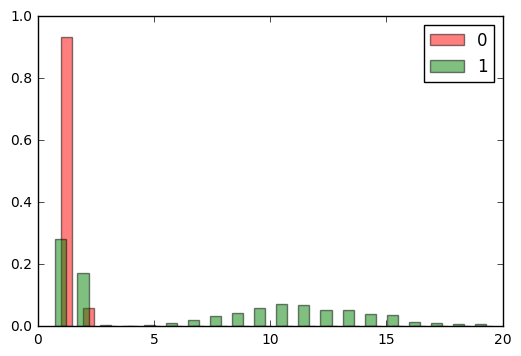

In [6]:
class0 = df.loc[df['class'] == 0]
class1 = df.loc[df['class'] == 1]
df_hist(class0, class1, 'nr_users')

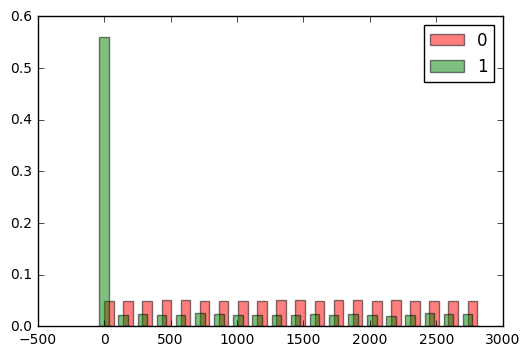

In [7]:
df_hist(class0, class1, 'time')

# Split training / test sets

In [34]:
# split each class into train / test sets
(train0, test0) = train_test_split(class0)
(train1, test1) = train_test_split(class1)
print "size of train0: %s, test0: %s, train1: %s, test1: %s\n" % (len(train0), len(test0), len(train1), len(test1))

size of train0: 95872, test0: 41089, train1: 9905, test1: 4246



# Naive Bayes classifier

In [ ]:
# fit kernel density models on training data for continuous features
density_smoothing = 0.25
absolute_tolerance = 1E-8 # leads to faster execution
kde_time0 = KernelDensity(kernel='gaussian', bandwidth=density_smoothing, atol=absolute_tolerance).fit(train0['time'].values.reshape(-1, 1))
kde_time1 = KernelDensity(kernel='gaussian', bandwidth=density_smoothing, atol=absolute_tolerance).fit(train1['time'].values.reshape(-1, 1))
kde_nr_users0 = KernelDensity(kernel='gaussian', bandwidth=density_smoothing, atol=absolute_tolerance).fit(train0['nr_users'].values.reshape(-1, 1))
kde_nr_users1 = KernelDensity(kernel='gaussian', bandwidth=density_smoothing, atol=absolute_tolerance).fit(train1['nr_users'].values.reshape(-1, 1))

In [37]:
# calculate marginal probabilities for continuous features
test0.loc[:,'p_time0'] = np.exp(kde_time0.score_samples(test0['time'].values.reshape(-1, 1)))
test1.loc[:,'p_time0'] = np.exp(kde_time0.score_samples(test1['time'].values.reshape(-1, 1)))
test0.loc[:,'p_time1'] = np.exp(kde_time1.score_samples(test0['time'].values.reshape(-1, 1)))
test1.loc[:,'p_time1'] = np.exp(kde_time1.score_samples(test1['time'].values.reshape(-1, 1)))
test0.loc[:,'p_nr_users0'] = np.exp(kde_nr_users0.score_samples(test0['nr_users'].values.reshape(-1, 1)))
test1.loc[:,'p_nr_users0'] = np.exp(kde_nr_users0.score_samples(test1['nr_users'].values.reshape(-1, 1)))
test0.loc[:,'p_nr_users1'] = np.exp(kde_nr_users1.score_samples(test0['nr_users'].values.reshape(-1, 1)))
test1.loc[:,'p_nr_users1'] = np.exp(kde_nr_users1.score_samples(test1['nr_users'].values.reshape(-1, 1)))

In [62]:
# use Bayes rule to calculate P(fraud)
test0.loc[:, 'p_fraud'] = test0.p_nr_users1*test0.p_time1*p_fraud/(test0.p_nr_users0*test0.p_time0*(1 - p_fraud) + test0.p_nr_users1*test0.p_time1*p_fraud)
test1.loc[:, 'p_fraud'] = test1.p_nr_users1*test1.p_time1*p_fraud/(test1.p_nr_users0*test1.p_time0*(1 - p_fraud) + test1.p_nr_users1*test1.p_time1*p_fraud)

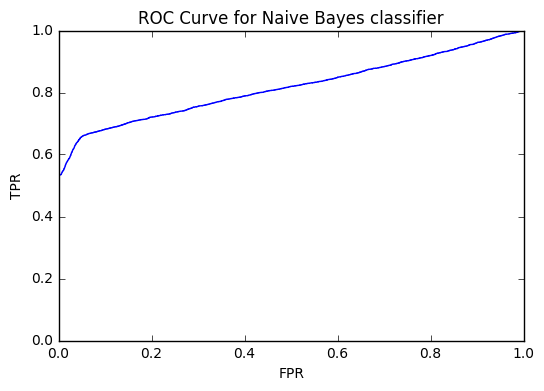

roc_auc_score = 0.816906


In [72]:
# Plot ROC curve
y_true = np.r_[test0['class'], test1['class']]
y_score = np.r_[test0['p_fraud'], test1['p_fraud']]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.plot(fpr, tpr)
plt.title('ROC Curve for Naive Bayes classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print "roc_auc_score = %f" % roc_auc_score(y_true, y_score)